In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def getCloseDataPandas(ticker, start,end=None):
    print(ticker)
    return data.get_data_yahoo(ticker, start,end)['Close']

def getCloseData(ticker, start, end=None):
    print(ticker)
    return fdr.DataReader(ticker,start,end)['Close']

def getDayReturn(closeDataSet):
    return (closeDataSet/closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight = None):
    dayReturn = getDayReturn(closeDataSet)
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    portfolioCumulativeReturn = (weight*cumulativeReturn).sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn/portfolioCumulativeReturn.shift(1)).fillna(1)
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    dd = (cumulativeReturn.cummax() - cumulativeReturn)/ cumulativeReturn.cummax()*100
    
    plt.figure(figsize=(15,5))
    plt.plot(-dd, label="DrawDown")
    plt.legend(fontsize = 16)
    mdd = dd.max()
    
    print(f"최종 수익률 : {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")
    return cagr,dd,mdd


def getRebalancingDate(closeDataSet, period="month"):
    data = closeDataSet.copy()
    data = pd.DataFrame(data) 
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "quarter":
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) 
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                                index=rebalancingDate,
                                columns=closeDataSet.columns)
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) 
    portfolio = pd.DataFrame()
    totalAsset = 1 
    start = rebalancingDate[0] 
    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start]
        priceData = closeDataSet.loc[start:end] 
        cumReturn = getCumulativeReturn(priceData) 
        weightedCumReturn = weight * cumReturn 
        netCumReturn = totalAsset * weightedCumReturn
        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum()
        portfolio = pd.concat([portfolio, netCumReturn])
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] 
    portfolioCumulativeReturn = portfolio.sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)
    
    return portfolioDayReturn, portfolioCumulativeReturn

### 모멘텀 계산 방법

In [26]:
# 데이터 로드 :1년치
kodex200 = getCloseData("069500", "2021-9-1","2022-9-30")
kodex200

069500


Date
2021-09-01    41200
2021-09-02    40823
2021-09-03    41087
2021-09-06    41230
2021-09-07    40984
              ...  
2022-09-26    29050
2022-09-27    29105
2022-09-28    28390
2022-09-29    28400
2022-09-30    28275
Name: Close, Length: 266, dtype: int64

In [27]:
# 리밸런싱 일자
rebalDate = getRebalancingDate(kodex200)
rebalDate

DatetimeIndex(['2021-09-30', '2021-10-29', '2021-11-30', '2021-12-30',
               '2022-01-28', '2022-02-28', '2022-03-31', '2022-04-29',
               '2022-05-31', '2022-06-30', '2022-07-29', '2022-08-31',
               '2022-09-30'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [28]:
len(rebalDate)

13

In [29]:
# 리밸런싱 일자 종가 데이터
priceOnRebalDate =  kodex200.loc[rebalDate]
priceOnRebalDate

Date
2021-09-30    39387
2021-10-29    38126
2021-11-30    36757
2021-12-30    39153
2022-01-28    35656
2022-02-28    36005
2022-03-31    36472
2022-04-29    35433
2022-05-31    35363
2022-06-30    30808
2022-07-29    32385
2022-08-31    32230
2022-09-30    28275
Name: Close, dtype: int64

In [30]:
len(priceOnRebalDate)

13

In [32]:
n = 1
rebalanceDataSet = pd.concat([priceOnRebalDate, priceOnRebalDate.shift(n).fillna(0)], axis=1)
#  priceOnRebalDate.shift(n): n달전 가격
rebalanceDataSet

,Close,Close
Date,,
2021-09-30,39387,0.0
2021-10-29,38126,39387.0
2021-11-30,36757,38126.0
2021-12-30,39153,36757.0
2022-01-28,35656,39153.0
2022-02-28,36005,35656.0
2022-03-31,36472,36005.0
2022-04-29,35433,36472.0
2022-05-31,35363,35433.0


## n개월 모멘텀(수익률을 이렇게 표현) = 현재 가격 / n개월 전 가격

In [33]:
# n개월 모멘텀 구하기
# n개월 모멘텀 = 현재 가격 / n개월 전 가격
# n개월 비율 모멘텀 = 이번 달 지수(종가=Close)값/n개월 전 지수(종가=Close)값
#출처: https://corianders.tistory.com/310 [코리안더의 일상 블로그:티스토리]
        
# n개월 수익률과 같은 개념

n = 1 # 1개월전 대비 현재의 수익률

momentum = (priceOnRebalDate / priceOnRebalDate.shift(n)).fillna(0)
data_df = pd.DataFrame(momentum)



In [37]:
monthlyDataSet = pd.concat([priceOnRebalDate, priceOnRebalDate.shift(n).fillna(0), data_df], axis=1)
monthlyDataSet.columns = ['당월종가', '전월종가', '상승율']
monthlyDataSet

,당월종가,전월종가,상승율
Date,,,
2021-09-30,39387,0.0,0.000000
2021-10-29,38126,39387.0,0.967984
2021-11-30,36757,38126.0,0.964093
2021-12-30,39153,36757.0,1.065185
2022-01-28,35656,39153.0,0.910684
2022-02-28,36005,35656.0,1.009788
2022-03-31,36472,36005.0,1.012970
2022-04-29,35433,36472.0,0.971512
2022-05-31,35363,35433.0,0.998024


**n개월 모멘텀 스코어: if n개월 모멘텀 > 1, 1, 0 (수익률이 1보다 크면 1, 1보가 작거나 같으면 0)**  


In [38]:
# n개월 모멘텀 스코어
# n개월 모멘텀 스코어: if n개월 모멘텀 > 1, 1, 0
n = 1
momentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(n) > 1, 1, 0)
momentumScore_df = pd.DataFrame(momentumScore, index=rebalDate)
momentumScoreDataSet = pd.concat([monthlyDataSet, momentumScore_df.fillna(0)], axis=1)
momentumScoreDataSet.columns = ['당월종가', '전월종가', '상승율', '1개월 모멘텀']
momentumScoreDataSet


,당월종가,전월종가,상승율,1개월 모멘텀
Date,,,,
2021-09-30,39387,0.0,0.000000,0
2021-10-29,38126,39387.0,0.967984,0
2021-11-30,36757,38126.0,0.964093,0
2021-12-30,39153,36757.0,1.065185,1
2022-01-28,35656,39153.0,0.910684,0
2022-02-28,36005,35656.0,1.009788,1
2022-03-31,36472,36005.0,1.012970,1
2022-04-29,35433,36472.0,0.971512,0
2022-05-31,35363,35433.0,0.998024,0


## n개월 평균 모멘텀 스코어: 1~n개월 모멘텀 스코어의 평균

In [39]:
n = 12
avgMomentumScore = 0
for i in range(1, n+1):
    avgMomentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(i) > 1, 1, 0) + avgMomentumScore
    data_df = pd.DataFrame(avgMomentumScore, index=rebalDate)
    rebalanceDataSet = pd.concat([priceOnRebalDate, priceOnRebalDate.shift(i).fillna(0), data_df], axis=1)
    rebalanceDataSet.columns=['당월종가', '전월종가', 'n개월 모멘텀']
    print("i = ", i)
    print(rebalanceDataSet)




i =  1
             당월종가     전월종가  n개월 모멘텀
Date                               
2021-09-30  39387      0.0        0
2021-10-29  38126  39387.0        0
2021-11-30  36757  38126.0        0
2021-12-30  39153  36757.0        1
2022-01-28  35656  39153.0        0
2022-02-28  36005  35656.0        1
2022-03-31  36472  36005.0        1
2022-04-29  35433  36472.0        0
2022-05-31  35363  35433.0        0
2022-06-30  30808  35363.0        0
2022-07-29  32385  30808.0        1
2022-08-31  32230  32385.0        0
2022-09-30  28275  32230.0        0
i =  2
             당월종가     전월종가  n개월 모멘텀
Date                               
2021-09-30  39387      0.0        0
2021-10-29  38126      0.0        0
2021-11-30  36757  39387.0        0
2021-12-30  39153  38126.0        2
2022-01-28  35656  36757.0        0
2022-02-28  36005  39153.0        1
2022-03-31  36472  35656.0        2
2022-04-29  35433  36005.0        0
2022-05-31  35363  36472.0        0
2022-06-30  30808  35433.0        0
2022-07-29  32

In [40]:
avgMomentumScore = avgMomentumScore / n
avgMomentumScore

array([0.        , 0.        , 0.        , 0.16666667, 0.        ,
       0.08333333, 0.16666667, 0.        , 0.        , 0.        ,
       0.08333333, 0.08333333, 0.        ])

### 평균모멘텀 스코어에 따른 투자 비중 계산

In [4]:
# 데이터 로드
kodex200 = getCloseData("069500", "2020", "2022-7-30") # 코스피200 ETF
kodex10Bond = getCloseData("152380", "2020", "2022-7-30") # kodex 국고채 10년물 etf

# kodex200 = 069500
# kodex10Bond = 152380
# S&P500 = SPY
# 미국 7-10 국채 = IEF

closeDataSet = pd.concat([kodex200, kodex10Bond], axis=1)
closeDataSet.columns = ['kodex200', 'kodex10Bond']
closeDataSet.dropna(inplace=True)
closeDataSet

069500
152380


,kodex200,kodex10Bond
Date,,
2020-01-02,27751,70720
2020-01-03,27747,71195
2020-01-06,27535,71320
2020-01-07,27812,70830
2020-01-08,27635,70795
...,...,...
2022-07-25,31910,64485
2022-07-26,32025,64640
2022-07-27,32035,64900


In [12]:
# 리밸런싱 일자
rebalDate = getRebalancingDate(closeDataSet)
# 리밸런싱 일자 종가 데이터
priceOnRebalDate =  closeDataSet.loc[rebalDate]

In [13]:
# 12개월 평균모멘텀스코어 계산
n = 12
avgMomentumScore = 0
for i in range(1, n+1):
    avgMomentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(i) > 1, 1, 0) + avgMomentumScore
    print(priceOnRebalDate.shift(i))
avgMomentumScore = pd.DataFrame(avgMomentumScore, index=priceOnRebalDate.index, columns=priceOnRebalDate.columns)
avgMomentumScore = avgMomentumScore / n
avgMomentumScore

            kodex200  kodex10Bond
Date                             
2020-01-31       NaN          NaN
2020-02-28   27231.0      71380.0
2020-03-31   25650.0      72870.0
2020-04-29   22720.0      71410.0
2020-05-29   24766.0      71690.0
2020-06-30   25681.0      72630.0
2020-07-31   26923.0      72695.0
2020-08-31   28758.0      73280.0
2020-09-29   29542.0      71985.0
2020-10-30   29869.0      72510.0
2020-11-30   29008.0      71860.0
2020-12-30   33381.0      71245.0
2021-01-29   38015.0      70915.0
2021-02-26   39625.0      70715.0
2021-03-31   40184.0      69700.0
2021-04-30   40647.0      69290.0
2021-05-31   41392.0      69005.0
2021-06-30   41847.0      68840.0
2021-07-30   42958.0      69415.0
2021-08-31   41631.0      70740.0
2021-09-30   41141.0      70660.0
2021-10-29   39387.0      68745.0
2021-11-30   38126.0      69400.0
2021-12-30   36757.0      68970.0
2022-01-28   39153.0      68840.0
2022-02-28   35656.0      66970.0
2022-03-31   36005.0      66685.0
2022-04-29   3

,kodex200,kodex10Bond
Date,,
2020-01-31,0.000000,0.000000
2020-02-28,0.000000,0.083333
2020-03-31,0.000000,0.083333
2020-04-29,0.083333,0.166667
2020-05-29,0.250000,0.250000
2020-06-30,0.333333,0.333333
2020-07-31,0.500000,0.500000
2020-08-31,0.583333,0.250000
2020-09-29,0.666667,0.333333


In [14]:
# 매월 평균 모멘텀 스코어
avgMomentumScore.sum(axis=1)

Date
2020-01-31    0.000000
2020-02-28    0.083333
2020-03-31    0.083333
2020-04-29    0.250000
2020-05-29    0.500000
2020-06-30    0.666667
2020-07-31    1.000000
2020-08-31    0.833333
2020-09-29    1.000000
2020-10-30    0.833333
2020-11-30    0.833333
2020-12-30    0.916667
2021-01-29    1.000000
2021-02-26    1.000000
2021-03-31    1.000000
2021-04-30    1.000000
2021-05-31    1.000000
2021-06-30    1.250000
2021-07-30    1.333333
2021-08-31    1.083333
2021-09-30    0.333333
2021-10-29    0.583333
2021-11-30    0.250000
2021-12-30    0.333333
2022-01-28    0.000000
2022-02-28    0.083333
2022-03-31    0.166667
2022-04-29    0.000000
2022-05-31    0.000000
2022-06-30    0.000000
2022-07-29    0.333333
dtype: float64

In [15]:
# 평균 모멘텀 스코어에 따른 투자 비중 계산
weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0)
weight

,kodex200,kodex10Bond
Date,,
2020-01-31,0.000000,0.000000
2020-02-28,0.000000,1.000000
2020-03-31,0.000000,1.000000
2020-04-29,0.333333,0.666667
2020-05-29,0.500000,0.500000
2020-06-30,0.500000,0.500000
2020-07-31,0.500000,0.500000
2020-08-31,0.700000,0.300000
2020-09-29,0.666667,0.333333


In [16]:
# 주식, 채권의 비중이 모두 0인 구간에는 현금으로 보유합니다.
weight['cash'] = np.where(weight.sum(axis=1) == 0, 1, 0)
weight

,kodex200,kodex10Bond,cash
Date,,,
2020-01-31,0.000000,0.000000,1
2020-02-28,0.000000,1.000000,0
2020-03-31,0.000000,1.000000,0
2020-04-29,0.333333,0.666667,0
2020-05-29,0.500000,0.500000,0
2020-06-30,0.500000,0.500000,0
2020-07-31,0.500000,0.500000,0
2020-08-31,0.700000,0.300000,0
2020-09-29,0.666667,0.333333,0


### 함수화

In [3]:
def getWeightByAvgMomentumScore(closeDataSet, n = 12):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """
    avgMomentumScore = 0 # 평모스 초기값
    priceOnRebalDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] # 리밸런싱 일자의 가격 데이터
    
    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(priceOnRebalDate / priceOnRebalDate.shift(i) > 1, 1, 0) + avgMomentumScore
        
    # 평균 모멘텀 스코어 계산
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=priceOnRebalDate.index, columns=priceOnRebalDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / n
    
    # 모멘텀 스코어에 따른 weight 계산
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0)
    # 투자 비중이 모두 0인 구간에서는 현금 보유
    weight['cash'] = np.where(weight.sum(axis=1) == 0, 1, 0)
    
    # 투자비중, 평균 모멘텀 스코어 리턴
    return weight, avgMomentumScore

In [5]:
closeDataSet

,kodex200,kodex10Bond
Date,,
2020-01-02,27751,70720
2020-01-03,27747,71195
2020-01-06,27535,71320
2020-01-07,27812,70830
2020-01-08,27635,70795
...,...,...
2022-07-25,31910,64485
2022-07-26,32025,64640
2022-07-27,32035,64900


In [5]:
weight6, avgMomentumScore6 = getWeightByAvgMomentumScore(closeDataSet, n=6)
weight12, avgMomentumScore12 = getWeightByAvgMomentumScore(closeDataSet, n=12)

In [7]:
avg

,kodex200,kodex10Bond,cash
Date,,,
2020-01-31,0.000000,0.000000,1
2020-02-28,0.000000,1.000000,0
2020-03-31,0.000000,1.000000,0
2020-04-29,0.333333,0.666667,0
2020-05-29,0.500000,0.500000,0
2020-06-30,0.500000,0.500000,0
2020-07-31,0.500000,0.500000,0
2020-08-31,0.700000,0.300000,0
2020-09-29,0.666667,0.333333,0


In [7]:
pd.set_option('display.max_rows', None)

In [8]:
avgMomentumScore12

,kodex200,kodex10Bond
Date,,
2020-01-31,0.000000,0.000000
2020-02-28,0.000000,0.083333
2020-03-31,0.000000,0.083333
2020-04-29,0.083333,0.166667
2020-05-29,0.250000,0.250000
2020-06-30,0.333333,0.333333
2020-07-31,0.500000,0.500000
2020-08-31,0.583333,0.250000
2020-09-29,0.666667,0.333333


In [8]:
weight6

,kodex200,kodex10Bond,cash
Date,,,
2020-01-31,0.000000,0.000000,1
2020-02-28,0.000000,1.000000,0
2020-03-31,0.000000,1.000000,0
2020-04-29,0.333333,0.666667,0
2020-05-29,0.500000,0.500000,0
2020-06-30,0.500000,0.500000,0
2020-07-31,0.500000,0.500000,0
2020-08-31,0.750000,0.250000,0
2020-09-29,0.666667,0.333333,0


In [22]:
weight12

,kodex200,kodex10Bond,cash
Date,,,
2020-01-31,0.000000,0.000000,1
2020-02-28,0.000000,1.000000,0
2020-03-31,0.000000,1.000000,0
2020-04-29,0.333333,0.666667,0
2020-05-29,0.500000,0.500000,0
2020-06-30,0.500000,0.500000,0
2020-07-31,0.500000,0.500000,0
2020-08-31,0.700000,0.300000,0
2020-09-29,0.666667,0.333333,0


### 백테스트

#### **투자 비중이 0인 구간에는 현금을 보유. 따라서, closeDataSet에도 현금을 추가**

- 현금의 가격은 1로 간주합니다.
- 단기 예적금 등으로 1~2% 연 수익률을 얻을 수는 있지만,
- 보수적인 관점에서 백테스트하기 위함입니다.

In [10]:
closeDataSet

,kodex200,kodex10Bond
Date,,
2020-01-02,27751,70720
2020-01-03,27747,71195
2020-01-06,27535,71320
2020-01-07,27812,70830
2020-01-08,27635,70795
...,...,...
2022-07-25,31910,64485
2022-07-26,32025,64640
2022-07-27,32035,64900


In [11]:
closeDataSet['cash'] = 1
closeDataSet

,kodex200,kodex10Bond,cash
Date,,,
2020-01-02,27751,70720,1
2020-01-03,27747,71195,1
2020-01-06,27535,71320,1
2020-01-07,27812,70830,1
2020-01-08,27635,70795,1
...,...,...,...
2022-07-25,31910,64485,1
2022-07-26,32025,64640,1
2022-07-27,32035,64900,1


**12개월 평균 모멘텀 스코어 투자 비중을 이용한 백테스트**

12개월 평균 모멘텀 스코어 최종수익률: 1.2440439808159642
최종 수익률 : 1.2440439808159642
cagr: 1.092970420917675
mdd: 19.468388069150798


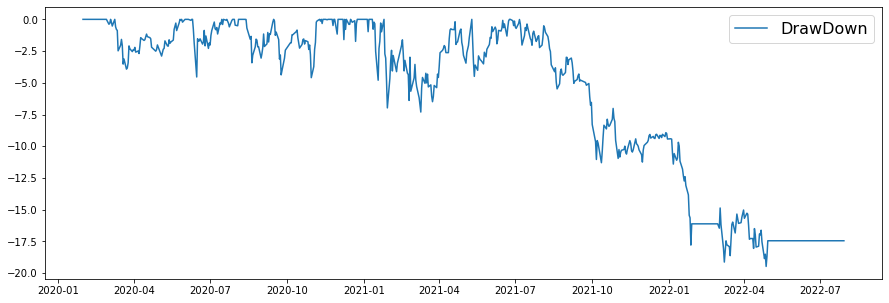

In [12]:
_, momentum12CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=weight12)

print(f"12개월 평균 모멘텀 스코어 최종수익률: {momentum12CumReturn.iloc[-1]}")
cagr12, dd12, mdd12 = getEvaluation(momentum12CumReturn)

**6개월 평균 모멘텀 스코어 투자 비중을 이용한 백테스트**

6개월 평균 모멘텀 스코어 최종수익률: 1.318175246120836
최종 수익률 : 1.318175246120836
cagr: 1.119030847504565
mdd: 15.900267540168095


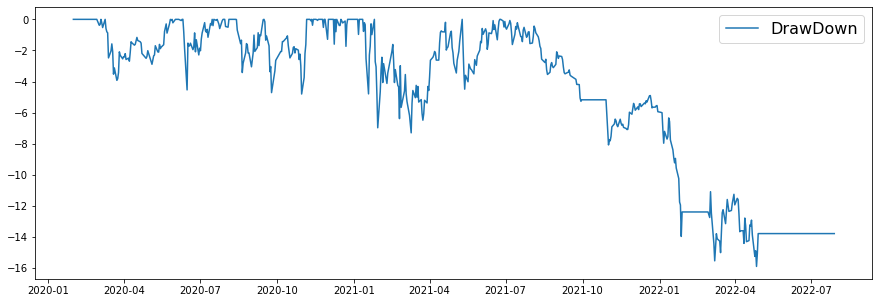

In [13]:
_, momentum6CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=weight6)

print(f"6개월 평균 모멘텀 스코어 최종수익률: {momentum6CumReturn.iloc[-1]}")
cagr6, dd6, mdd6 = getEvaluation(momentum6CumReturn)

**시장수익률 계산 (코스피200)**

In [14]:
rebalDate = getRebalancingDate(closeDataSet)

시장 최종수익률: 1.1892695824611657
최종 수익률 : 1.1892695824611657
cagr: 1.0731173954851394
mdd: 33.967353714206666


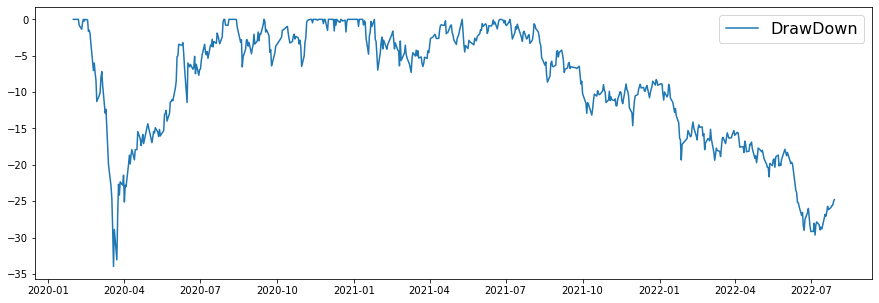

In [15]:
stockCumReturn = getCumulativeReturn(kodex200.loc[rebalDate[0]:])

print(f"시장 최종수익률: {stockCumReturn.iloc[-1]}")
stockCagr, stockDD, stockMDD = getEvaluation(stockCumReturn)

**시각화 비교**

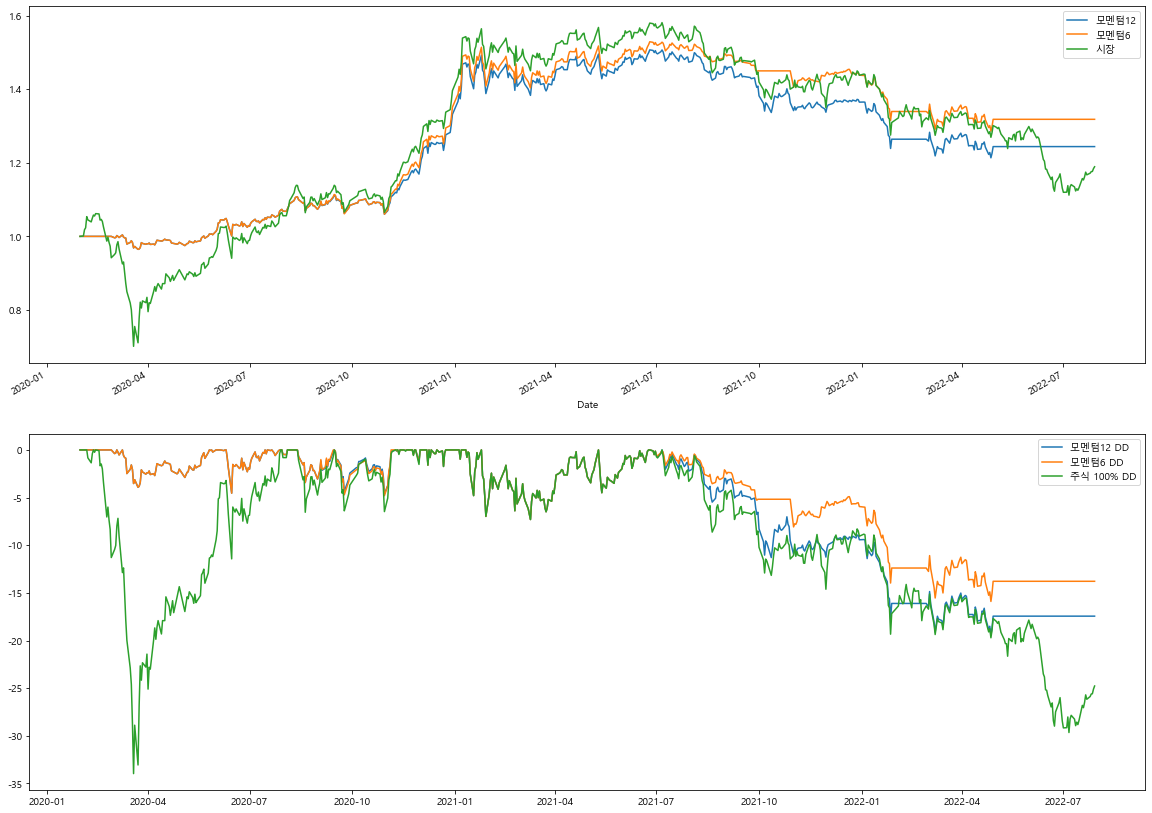

In [16]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,16))

# 수익곡선
plt.subplot(2,1,1)
momentum12CumReturn.plot(label="모멘텀12")
momentum6CumReturn.plot(label="모멘텀6")
stockCumReturn.plot(label="시장")
plt.legend()

# dd 곡선
plt.subplot(2,1,2)
plt.plot(-dd12, label="모멘텀12 DD")
plt.plot(-dd6, label="모멘텀6 DD")
plt.plot(-stockDD, label="주식 100% DD")
plt.legend()

plt.show()

시장 : buy &hold
오렌지 :6개월 momen


### 과제
#### 1. 위의 누적수익률 그래프에서 잘못된 점을 찾아 이를 바로 잡는 코드를 작성하시오.
#### 2. 위의 DD 그래프에서 잘못된 점을 찾아 이를 바로 잡는 코드를 작성하시오.**